In [115]:
import numpy as np

# **1**

In [116]:
#Ejercicio 1. a)
def codifica_aux(decimal,nBit):
    #Utilizamos como parametro un número natural en decimal y la cantidad de bits que queremos utilizar en el arreglo para decodificar
    binary = np.zeros(nBit,dtype=int)
    i = nBit - 1
    while decimal > 0:
        binary[i] = decimal % 2
        #Establecemos ahora al número natural como la división entera del numero anterior
        decimal //=2
        i-=1
    return binary

def decodifica_aux(binary):
    #Utilizamos como parametros un arreglo de bits e inicializamos un número decimal
    decimal = 0 
    for i in range(len(binary)):
        #Utilizando el algoritmo para convertir de binario a decimal
        decimal += binary[i]*2**(len(binary)-i-1)
    return decimal

In [117]:
#Ejercicio 1. c)
def codifica(x,nBit,a,b):
    # x es el número real que queremos codificar
    # nBit es la cantidad de Bits con la que queremos representar el número real
    # a es el límite inferior del intervalo donde se encuentra el número a evaluar
    # b es el límite superior, es importante que a sea menor que b
    # Calculamos la precisión dividiendo la longitud del intervalo entre el número de reales que podemos representar con nBits
    precision = (b-a)/(2**nBit)
    #Checamos que el número que queremos codificar se encuentra dentro del intervalo
    x= max(a,min(b,x))
    #Le asignamos una posición en el intervalo a x
    index = int((x-a)/precision)
    #Convertimos a binario
    binary = codifica_aux(index,nBit)
    return binary

#Ejercicio 1. d)
def decodifica(x_cod,nBit,a,b):
    #x_cod ahora es el arreglo de bits 
    precision = (b-a)/(2**nBit)
    #Hacemos un proceso inverso a la función de codificación
    index = decodifica_aux(x_cod)
    #Establecemos al número decimal como x y lo definimos conforme a la función anterior
    x = a+ index *precision
    return x

In [118]:
#Ejercicio 1. e)
def codifica_v(x,nBit,a,b):
    binary = list()
    #En este caso x es un vector de números reales que queremos codificar
    for i in x:
        binary.append(codifica(i,nBit,a,b))
    return binary

def decodifica_v(x_cod,nBit,a,b):
    decimal = list()
    #x_cod es un vector de arreglos de bits para convertir a decimal
    for i in x_cod:
        decimal.append(decodifica(i,nBit,a,b))
    return decimal        

# **2**

## **En caso de no tener instalado lo siguiente, instalarlo con los siguientes comandos:**

In [119]:
# pip install numpy
# pip install matplotlib
# pip install pandas
# pip install networkx

## **Importamos las librerías que vamos a usar**

In [120]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import networkx as nx

In [121]:
# Definimos nuestro lector de archivos .col
# Y creamos una grafica en base a lo recolectado en el archivo
"""
Un ejemplo es esta grafica de 4 vertices y 5 aristas, con aristas entre 1 y 2, 1 y 3, 1 y 4, 2 y 4, 3 y 4
c Archivo: prueba1.col
p edge 4 5
e 1 2
e 1 3
e 1 4
e 2 4
e 3 4

Ahora tendremos este ejemplo de grafica con 9 vertices y 6 aristas, con aristas entre 1 y 2, 1 y 9, 2 y 3, 4 y 5, 6 y 7, 8 y 9
c Archivo: prueba2.col
p edge 9 6
e 1 2
e 1 9
e 2 3
e 4 5
e 6 7
e 8 9



"""
def leer_ArchivoCol(archivo):
    vertices = set()
    aristas = []

    with open(archivo, 'r') as f:
        for linea in f:
            # Ignorar comentarios
            if linea.startswith('c'):
                continue
            
            # Leer información de la instancia
            if linea.startswith('p'):
                _, _, n_vertices, n_aristas = linea.split()
                n_vertices = int(n_vertices)
                n_aristas = int(n_aristas)
            elif linea.startswith('e'):
                _, v1, v2 = linea.split()
                v1 = int(v1)
                v2 = int(v2)
                aristas.append((v1, v2))
                vertices.add(v1)
                vertices.add(v2)
    
    return n_vertices, n_aristas, list(vertices), aristas


Número de vértices: 4
Número de aristas: 5
Vértices: [1, 2, 3, 4]
Aristas: [(1, 2), (1, 3), (1, 4), (2, 4), (3, 4)]


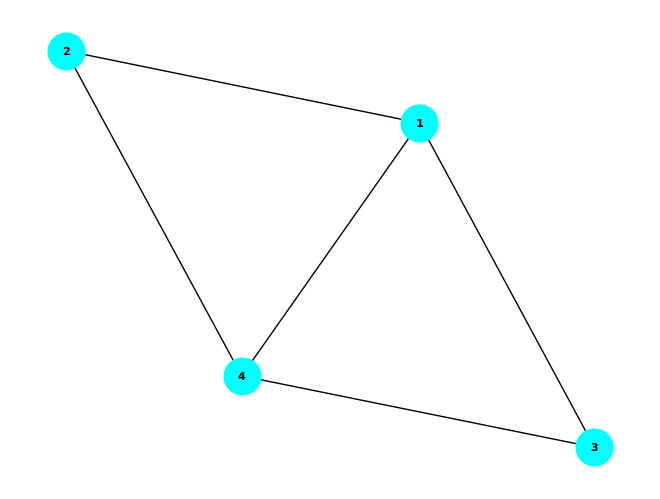

In [122]:
# Definimos una funcion que dibuje la grafica que obtuvimos anteriormente

def dibujar_Grafica(vertices, aristas):
    G = nx.Graph()
    G.add_nodes_from(vertices)
    G.add_edges_from(aristas)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='cyan', font_size=8, font_weight='bold')

    plt.show()


"""
Usamos como ejemplo a prueba1.col para probar las funciones anteriores

Recordemos que este archivo modela la grafica:
              1──────3
              │╲     │
              │ ╲    │
              │  ╲   │
              │   ╲  │
              │    ╲ │
              2──────4
"""

archivo = 'prueba1.col'
n_vertices, n_aristas, vertices, aristas = leer_ArchivoCol(archivo)

print("Número de vértices:", n_vertices)
print("Número de aristas:", n_aristas)
print("Vértices:", vertices)
print("Aristas:", aristas)

dibujar_Grafica(vertices, aristas)




## **Esquema de representación de soluciones.**

In [123]:
class SColoracion:
    def __init__(self, n_vertices, colores_asignados=None):
        self.n_vertices = n_vertices
        if colores_asignados is None:
            self.colores_asignados = [-1] * n_vertices  # Inicialmente ningún vértice tiene color asignado
        else:
            self.colores_asignados = colores_asignados
    
    def asignar_color(self, vertice, color):
        self.colores_asignados[vertice - 1] = color  # Los índices de los vértices empiezan en 1
    
    def obtener_color(self, vertice):
        if vertice > 0 and vertice <= self.n_vertices:
            return self.colores_asignados[vertice - 1]
        else:
            raise ValueError("El vértice especificado está fuera del rango.")

### **Declaramos la siguiente funcion auxiliar para mapear colores a un numero entero de entrada**

In [124]:
'''
Colores disponibles en NetworkX:
Azul: 'b', 'blue', 'navy', 'skyblue', 'cyan'
Rojo: 'r', 'red', 'darkred', 'tomato', 'crimson'
Verde: 'g', 'green', 'forestgreen', 'limegreen', 'seagreen'
Amarillo: 'y', 'yellow', 'gold', 'khaki', 'lightyellow'
Morado: 'm', 'magenta', 'purple', 'deeppink', 'fuchsia'
Naranja: 'o', 'orange', 'darkorange', 'burntorange', 'coral'
Negro: 'k', 'black', 'gray', 'darkgray', 'silver'
Blanco: 'w', 'white', 'ivory', 'snow', 'ghostwhite'
'''
def mapear_color(numero):
    '''
    colores = ['b', 'blue', 'navy', 'skyblue', 'cyan',
               'r', 'red', 'darkred', 'tomato', 'crimson',
               'g', 'green', 'forestgreen', 'limegreen', 'seagreen',
               'y', 'yellow', 'gold', 'khaki', 'lightyellow',
               'm', 'magenta', 'purple', 'deeppink', 'fuchsia',
               'o', 'orange', 'darkorange', 'burntorange', 'coral',
               'k', 'black', 'gray', 'darkgray', 'silver',
               'w', 'white', 'ivory', 'snow', 'ghostwhite'] 
    '''
    colores = ['#0000FF', '#00FFFF', '#000080', '#87CEEB', '#008B8B',
               '#FF0000', '#FF6347', '#8B0000', '#FF4500', '#DC143C',
               '#008000', '#008000', '#228B22', '#32CD32', '#2E8B57',
               '#FFFF00', '#FFFF00', '#FFD700', '#F0E68C', '#FFFFE0',
               '#FF00FF', '#FF00FF', '#800080', '#FF1493', '#FF00FF',
               '#FFA500', '#FF8C00', '#FF7F50', '#FF8C00', '#FF7F50',
               '#000000', '#808080', '#A9A9A9', '#808080', '#C0C0C0',
               '#FFFFFF', '#FFFFFF', '#FFFFF0', '#FFFAFA', '#F8F8FF']
    return colores[numero % len(colores)]


### **La funcion de evaluacion que usaremos**

In [125]:
def zakharov(x):
    x = pd.Series(x)
    d = len(x)
    t1 = sum(x**2)
    t2 = 0.5*sum(range(d)*(x**2))
    y = t1 + (t2**2) + (t2**4)
    return y

In [126]:
# funcion auxiliar que devuelve una lista con los colores (en numero) de los vecinos de un vertice
# entrada: Solucion, vertice
# salida: lista con los colores de los vecinos
def coloresVecinos(solucion, vertice):
    vecinos = [v for v1, v2 in aristas if v1 == vertice for v in [v2]] + [v for v1, v2 in aristas if v2 == vertice for v in [v1]]
    colores = [solucion.obtener_color(v) for v in vecinos]
    return colores

### **Generacion de soluciones aleatorias**

Si bien seguimos una heuristica para brindar la solucion, estas serán aleatorias en el ambito de tener colores aleatorios en cada nodo
siempre y cuando no se repitan colores en los nodos adyacentes.

In [127]:
# Vamos a recibir un archivo el cual al leer con la funcion leer_ArchivoCol
# generaremos una grafica y apartir de los elementos de esa grafica vamos a
# escoger un vertice aleatorio y asignarle un color aleatorio, despues vamos a 
# revisar quienes son los demas vertices y asignarles un color diferente (aleatorio) diferente en caso de que tengan vecinos con el mismo color
def colorearGraficaConNColores(archivo):
    n_vertices, n_aristas, vertices, aristas = leer_ArchivoCol(archivo)
    # dibujar_Grafica(vertices, aristas)
    n_colores = n_vertices # Como en el peor de los casos se necesitaran n_vertices colores, vamos a asignarle ese numero de colores
    solucion = SColoracion(n_vertices)
    vertices = list(range(1, n_vertices+1))

    #Ahora ordenamos la lista de vertices con los vertices de mayor a menor, iniciando por aquellos que tienen mas vecinos
    vertices.sort(key=lambda v: len([v1 for v1, v2 in aristas if v1 == v or v2 == v]), reverse=True)

    #vecinos = [v for v1, v2 in aristas if v1 == vertice for v in [v2]] + [v for v1, v2 in aristas if v2 == vertice for v in [v1]]

    for vertice in vertices:
        # Asignar un color aleatorio al vértice y verificar que ese color no esté asignado a ninguno de sus vecinos
        color = (random.randint(1, n_colores))
        while color in coloresVecinos(solucion, vertice):
            color = (random.randint(1, n_colores))
        solucion.asignar_color(vertice, color)
        
        #for vecino in vecinos:
        #    color = (random.randint(1, n_colores))
        #    solucion.asignar_color(vecino, color)
    return solucion


In [128]:
# Funcion copia de dibujarGrafica (hacen practicamente lo mismo)
def dibujar_Grafica_coloreado(solucion, vertices, aristas):
    G = nx.Graph()
    G.add_nodes_from(vertices)
    G.add_edges_from(aristas)
    pos = nx.spring_layout(G)
    colores = [mapear_color(solucion.obtener_color(v)) for v in vertices]
    nx.draw(G, pos, with_labels=True, node_size=700, node_color=colores, font_size=8, font_weight='bold')

    plt.show()


### **Probamos la solucion generada con lo siguiente**

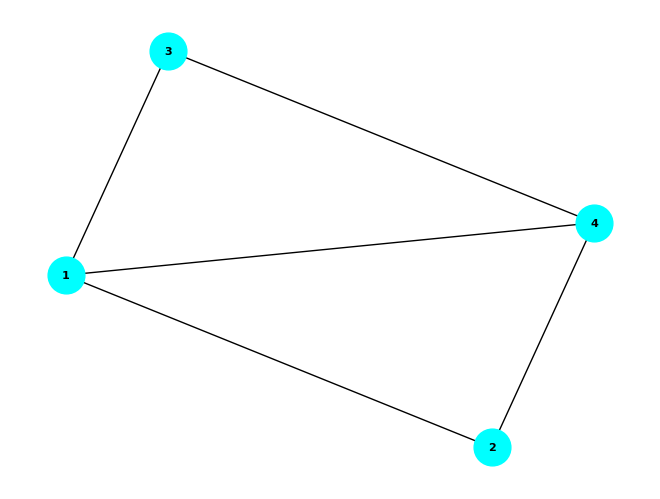

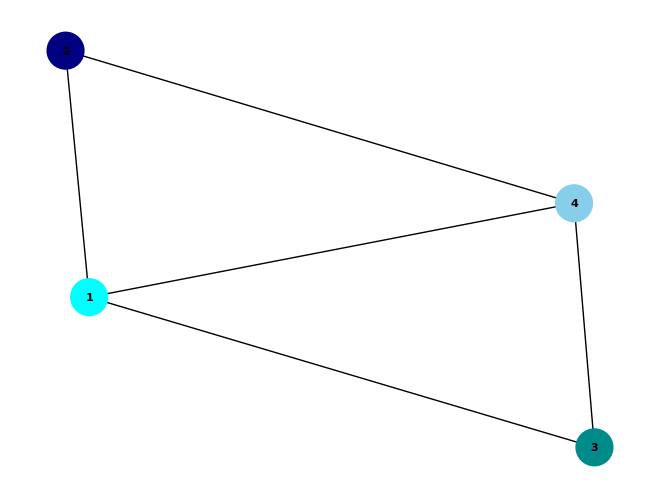

In [129]:
archivo = 'prueba1.col'
n_vertices, n_aristas, vertices, aristas = leer_ArchivoCol(archivo)

#print("Número de vértices:", n_vertices)
#print("Número de aristas:", n_aristas)
#print("Vértices:", vertices)
#print("Aristas:", aristas)

dibujar_Grafica(vertices, aristas)
solucion = colorearGraficaConNColores(archivo)
dibujar_Grafica_coloreado(solucion, vertices, aristas)

# Notese como primero dibujamos la grafica original y despues dibujamos el resultado de la solucion aleatoria


### **Vecindad de Soluciones**

In [130]:
# Funcion con la que generamos una solucion vecina a la generafa anteriormente
def generar_vecino(solucion_actual):
    """
    Genera una solución vecina modificando aleatoriamente un color de un vértice.

    Parámetros:
    solucion_actual : SColoracion
        Solución actual que se usará como base para generar la solución vecina.
    Devuelve:
    SColoracion
        Una instancia de la clase SColoracion que representa una solución vecina.
     
    """
    vertice_a_cambiar = random.randint(1, solucion_actual.n_vertices)
    color_asignado_actual = solucion_actual.obtener_color(vertice_a_cambiar)
    nuevo_color = color_asignado_actual
    while nuevo_color in coloresVecinos(solucion_actual, vertice_a_cambiar):
        nuevo_color = random.randint(1, solucion_actual.n_vertices)
    
    # Crear una copia de la solución actual y modificar el color del vértice seleccionado
    nueva_solucion = SColoracion(solucion_actual.n_vertices, solucion_actual.colores_asignados[:])
    nueva_solucion.asignar_color(vertice_a_cambiar, nuevo_color)
    return nueva_solucion

In [131]:
# Funcion que genera una vecindad de soluciones
def generarVecindad(solucion):
    vecindad = []
    for i in range(100):
        vecino = generar_vecino(solucion)
        vecindad.append(vecino)
    return vecindad


## **Busqueda por escalada**

Ya que contamos con una vecindad de soluciones para el problema de coloramiento, procedemos a implementar la busqueda por escalada
para buscar la solucion que mas se acerque a que tengamos el menor numero de colores posibles en la grafica.

In [132]:
# implementacion de la busqueda por escalada
def busquedaEscalada(archivo):
    solucion = colorearGraficaConNColores(archivo)
    costo = zakharov(solucion.colores_asignados)
    while True:
        vecindad = generarVecindad(solucion)
        mejor_vecino = min(vecindad, key=lambda x: zakharov(x.colores_asignados))
        if zakharov(mejor_vecino.colores_asignados) < costo:
            solucion = mejor_vecino
            costo = zakharov(solucion.colores_asignados)
        else:
            break
    return solucion

# Funcion copia de dibujarGrafica (hacen practicamente lo mismo X2 XD)
def dibujarsolucionEscalada(solucion, vertices, aristas):
    G = nx.Graph()
    G.add_nodes_from(vertices)
    G.add_edges_from(aristas)
    pos = nx.spring_layout(G)
    colores = [mapear_color(solucion.obtener_color(v)) for v in vertices]
    nx.draw(G, pos, with_labels=True, node_size=700, node_color=colores, font_size=8, font_weight='bold')
    

    plt.show()


### Procedemos a probar nuestra busqueda por escalada

Número de vértices: 4
Número de aristas: 5
Vértices: [1, 2, 3, 4]
Aristas: [(1, 2), (1, 3), (1, 4), (2, 4), (3, 4)]
Solucion Aleatoria:


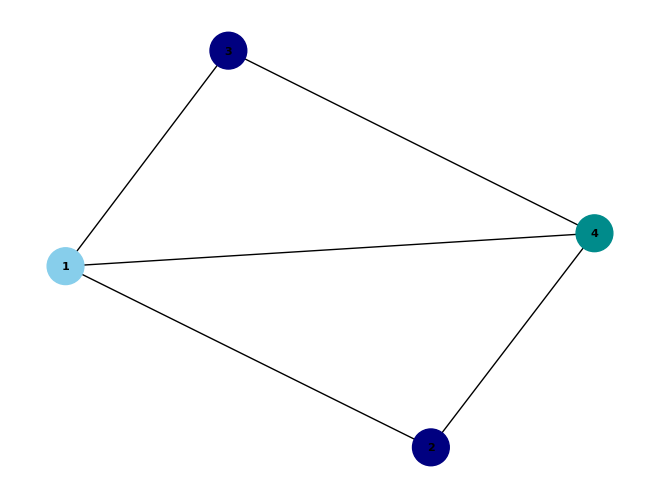

Solucion por escalada:


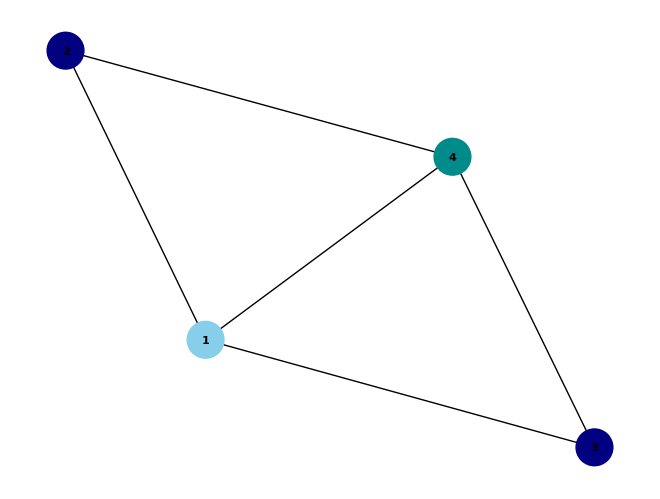

In [133]:
archivo = 'prueba1.col'
n_vertices, n_aristas, vertices, aristas = leer_ArchivoCol(archivo)

print("Número de vértices:", n_vertices)
print("Número de aristas:", n_aristas)
print("Vértices:", vertices)
print("Aristas:", aristas)

#dibujar_Grafica(vertices, aristas)
print("Solucion Aleatoria:")
solucion = colorearGraficaConNColores(archivo)
dibujar_Grafica_coloreado(solucion, vertices, aristas)

print("Solucion por escalada:")
solucionEscalada = busquedaEscalada(archivo)
dibujarsolucionEscalada(solucionEscalada, vertices, aristas)

### Prueba en grafica de 5 vértices y 7 aristas

Número de vértices: 5
Número de aristas: 7
Vértices: [1, 2, 3, 4, 5]
Aristas: [(4, 5), (1, 3), (2, 3), (2, 1), (2, 4), (3, 4), (4, 1)]
Solucion Aleatoria:


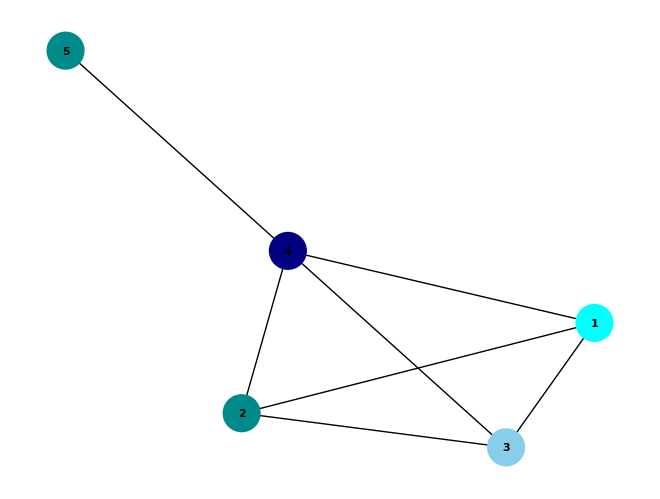

Solucion por escalada:


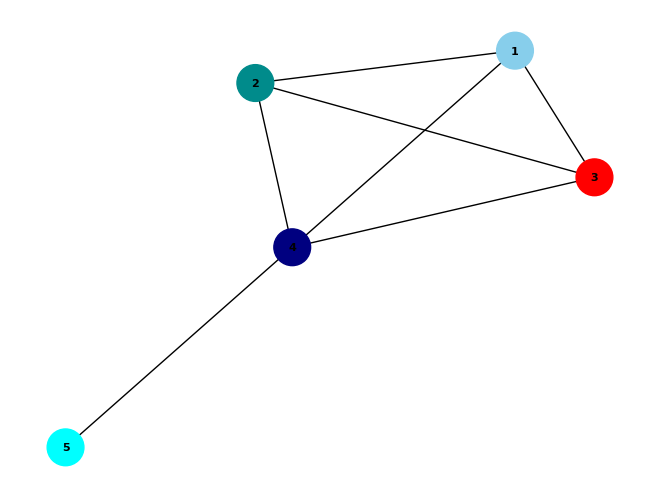

In [134]:
archivo = 'graficaPapalote.col'
n_vertices, n_aristas, vertices, aristas = leer_ArchivoCol(archivo)

print("Número de vértices:", n_vertices)
print("Número de aristas:", n_aristas)
print("Vértices:", vertices)
print("Aristas:", aristas)

#dibujar_Grafica(vertices, aristas)
print("Solucion Aleatoria:")
solucion = colorearGraficaConNColores(archivo)
dibujar_Grafica_coloreado(solucion, vertices, aristas)

print("Solucion por escalada:")
solucionEscalada = busquedaEscalada(archivo)
dibujarsolucionEscalada(solucionEscalada, vertices, aristas)

### Prueba en grafica de 10 vértices y 15 aristas

Número de vértices: 10
Número de aristas: 15
Vértices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Aristas: [(1, 2), (1, 3), (2, 3), (2, 5), (3, 5), (3, 6), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7), (7, 1), (8, 2), (9, 3), (10, 5)]
Solucion Aleatoria:


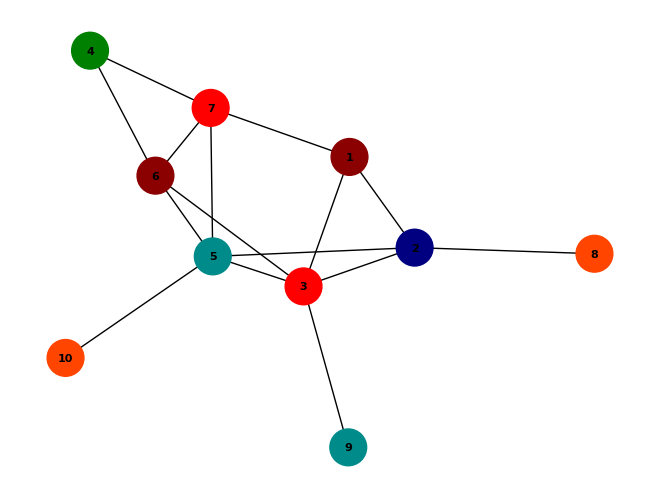

Solucion por escalada:


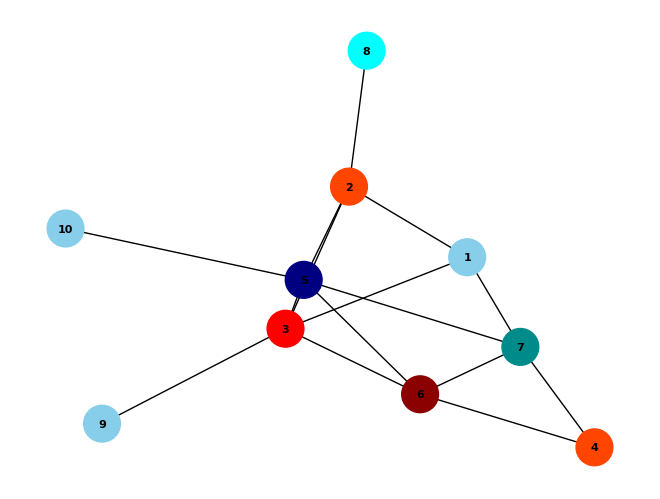

In [135]:
archivo = 'graficaTres.col'
n_vertices, n_aristas, vertices, aristas = leer_ArchivoCol(archivo)

print("Número de vértices:", n_vertices)
print("Número de aristas:", n_aristas)
print("Vértices:", vertices)
print("Aristas:", aristas)

#dibujar_Grafica(vertices, aristas)
print("Solucion Aleatoria:")
solucion = colorearGraficaConNColores(archivo)
dibujar_Grafica_coloreado(solucion, vertices, aristas)

print("Solucion por escalada:")
solucionEscalada = busquedaEscalada(archivo)
dibujarsolucionEscalada(solucionEscalada, vertices, aristas)

In [136]:
"""
# Borrar los comentarios y cambiar el parametro nombreArchivo.col para probar con otro archivo y veer su coloracion
archivo = 'nombreArchivo.col'
n_vertices, n_aristas, vertices, aristas = leer_ArchivoCol(archivo)

print("Número de vértices:", n_vertices)
print("Número de aristas:", n_aristas)
print("Vértices:", vertices)
print("Aristas:", aristas)

print("Solucion Aleatoria:")
solucion = colorearGraficaConNColores(archivo)
dibujar_Grafica_coloreado(solucion, vertices, aristas)

print("Solucion por escalada:")
solucionEscalada = busquedaEscalada(archivo)
dibujarsolucionEscalada(solucionEscalada, vertices, aristas)
"""

'\n# Borrar los comentarios y cambiar el parametro nombreArchivo.col para probar con otro archivo y veer su coloracion\narchivo = \'nombreArchivo.col\'\nn_vertices, n_aristas, vertices, aristas = leer_ArchivoCol(archivo)\n\nprint("Número de vértices:", n_vertices)\nprint("Número de aristas:", n_aristas)\nprint("Vértices:", vertices)\nprint("Aristas:", aristas)\n\nprint("Solucion Aleatoria:")\nsolucion = colorearGraficaConNColores(archivo)\ndibujar_Grafica_coloreado(solucion, vertices, aristas)\n\nprint("Solucion por escalada:")\nsolucionEscalada = busquedaEscalada(archivo)\ndibujarsolucionEscalada(solucionEscalada, vertices, aristas)\n'

Mejor solución encontrada: [9, 6, 8, 7, 6, 8, 10, 2, 4, 5, 7, 5, 3, 5, 11, 10, 4, 9, 3, 1, 9]
Número de vértices: 21
Número de aristas: 21
Número de colores: 11


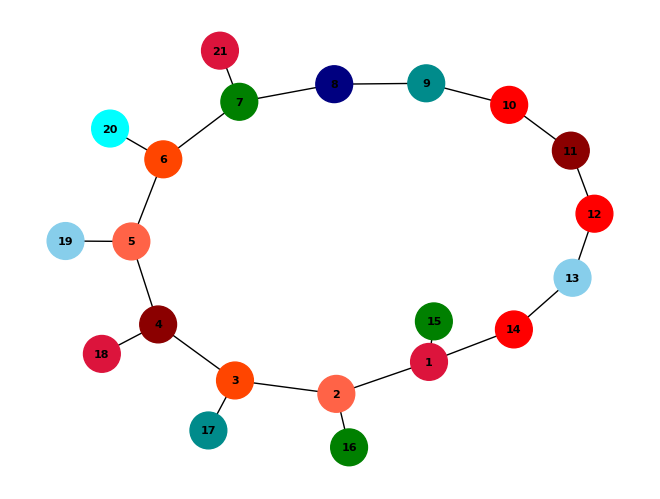

In [172]:
import random
import copy
#import matplotlib.pyplot as plt
#import networkx as nx

# Generamos una solución inicial aleatoria con colorearGraficaConNColores
# generar_solucion_inicial
def colorearGraficaConNColores2(archivo):
    n_vertices, n_aristas, vertices, aristas = leer_ArchivoCol(archivo)
    # dibujar_Grafica(vertices, aristas)
    n_colores = n_vertices # Como en el peor de los casos se necesitaran n_vertices colores, vamos a asignarle ese numero de colores
    solucion = SColoracion(n_vertices)
    vertices = list(range(1, n_vertices+1))

    #Ahora ordenamos la lista de vertices con los vertices de mayor a menor, iniciando por aquellos que tienen mas vecinos
    vertices.sort(key=lambda v: len([v1 for v1, v2 in aristas if v1 == v or v2 == v]), reverse=True)

    #vecinos = [v for v1, v2 in aristas if v1 == vertice for v in [v2]] + [v for v1, v2 in aristas if v2 == vertice for v in [v1]]

    for vertice in vertices:
        # Asignar un color aleatorio al vértice y verificar que ese color no esté asignado a ninguno de sus vecinos
        color = (random.randint(1, n_colores))
        while color in coloresVecinos(solucion, vertice):
            color = (random.randint(1, n_colores))
        solucion.asignar_color(vertice, color)
        
        #for vecino in vecinos:
        #    color = (random.randint(1, n_colores))
        #    solucion.asignar_color(vecino, color)
    # Regresamos una lista de con los colores de la solucion
    return solucion.colores_asignados


# Función para generar una solución vecina modificando algunos vértices
# generar_vecino
def generar_vecino_iterada(solucion_actual, n_colores):
    vecino = copy.deepcopy(solucion_actual)
    vertice_a_modificar = random.randint(0, len(solucion_actual) - 1)
    nuevo_color = random.randint(1, n_colores)
    vecino[vertice_a_modificar] = nuevo_color
    return vecino


# Función para evaluar la calidad de una solución (número de colores utilizados, estos deben ser como maximo el numero de vertices)
# En caso de que se utilicen mas colores que vertices, se penalizara con un valor muy alto o si por el contrario se asigna el mismo color a 
# dos vertices que son adyacentes, tambien se penalizara con un valor muy alto
def evaluar_solucion(solucion):
    n_colores = max(solucion)
    if n_colores > len(solucion):
        return float('inf')
    for v1, v2 in aristas:
        if solucion[v1 - 1] == solucion[v2 - 1]:
            return float('inf')
    return n_colores



# Función para dibujar la gráfica con la coloración dada
def dibujar_grafica_coloreada(vertices, aristas, colores):
    G = nx.Graph()
    G.add_nodes_from(vertices)
    G.add_edges_from(aristas)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=700, node_color=colores, font_size=8, font_weight='bold')
    plt.show()

# Función de búsqueda local iterada (ILS)
def busqueda_local_iterada(archivo, max_iteraciones, temperatura_inicial, factor_enfriamiento):
    n_vertices, _, _, _ = leer_ArchivoCol(archivo)
    n_colores = n_vertices # Se asignan inicialmente tantos colores como vértices
    mejor_solucion = None
    mejor_costo = float('inf')

    # Generar una solución inicial aleatoria
    solucion_actual = colorearGraficaConNColores2(archivo)
    costo_actual = evaluar_solucion(solucion_actual)

    # Búsqueda local iterada
    for _ in range(max_iteraciones):
        vecino = generar_vecino_iterada(solucion_actual, n_colores)
        costo_vecino = evaluar_solucion(vecino)

        # Aceptar la solución vecina si es mejor o con cierta probabilidad si es peor
        if costo_vecino < costo_actual:
            solucion_actual = vecino
            costo_actual = costo_vecino
        else:
            probabilidad_aceptacion = temperatura_inicial / (temperatura_inicial + 1)
            if random.random() < probabilidad_aceptacion:
                solucion_actual = vecino
                costo_actual = costo_vecino

        # Actualizar la mejor solución encontrada
        if costo_actual < mejor_costo:
            mejor_solucion = solucion_actual
            mejor_costo = costo_actual

        # Enfriar la temperatura
        temperatura_inicial *= factor_enfriamiento

    return mejor_solucion

# Parámetros del algoritmo
max_iteraciones = 10000000
temperatura_inicial = 500000
factor_enfriamiento = 0.99999999999999

# Ejemplo de uso del algoritmo
archivo = 'grafica_Grandota.col'
n_vertices, _, vertices, aristas = leer_ArchivoCol(archivo)

mejor_solucion = busqueda_local_iterada(archivo, max_iteraciones, temperatura_inicial, factor_enfriamiento)
print("Mejor solución encontrada:", mejor_solucion)

# Imprimimos el numero de vertices de la grafica
print("Número de vértices:", n_vertices)

# Imprimimos el numero de aristas de la grafica
print("Número de aristas:", len(aristas))

# Imprimimos el numero de colores que se usaron
print("Número de colores:", max(mejor_solucion))

# Convertir los colores de la solución a un formato compatible con la función de dibujo
colores = [mapear_color(color) for color in mejor_solucion]

# Dibujar la gráfica con la coloración resultante
dibujar_grafica_coloreada(vertices, aristas, colores)
